In [1]:
import time
import torch
from torch import nn
from ml_models import SuperResolutionNet
from datasets import SRDataset
from utils import *
import numpy as np
from scipy.interpolate import interp2d, RectBivariateSpline
from importlib import reload  

import pylab as plt
%matplotlib inline

import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

# Data parameters
data_folder = './exp2'  # folder with JSON data files
scaling_factor = 4  # the scaling factor for the generator; the input LR images will be downsampled from the target HR images by this factor


In [2]:
import diagnostics

def cal_enstrophy_spec(field2d):
    spec = diagnostics.grid2spec(field2d)
    return diagnostics.prod_spectrum(spec, spec)

def BivariateSplineInterp(low_res, scaling_factor):
    num_rows, num_cols = low_res.shape
    interp_f = RectBivariateSpline(np.linspace(0, 1, num_rows), np.linspace(0, 1, num_cols), low_res)

    interp_array = np.zeros((num_rows*scaling_factor, num_cols*scaling_factor))
    high_res_x = np.linspace(0, 1, num_rows * scaling_factor)
    high_res_y = np.linspace(0, 1, num_cols * scaling_factor)
    for i in range(num_rows * scaling_factor):
        for j in range(num_cols * scaling_factor):
            interp_array[i, j] = interp_f(high_res_x[i], high_res_y[j])
    
    return interp_array


In [25]:
train_dataset = SRDataset(data_folder,
                          scaling_factor=scaling_factor)
low_res, high_res = train_dataset[25]

interped_res = BivariateSplineInterp(low_res[0, :, :],  scaling_factor)

In [17]:
checkpoint = torch.load("/home/juchai/azblob/an_model/epoch195_checkpoint_srgan.pth.tar")
model = checkpoint['generator'].cpu()

In [26]:
with torch.no_grad():
    super_res = model(low_res).reshape(high_res.shape).detach().cpu().numpy()
    super_res = super_res.reshape(super_res.shape[1:])


if len(low_res.shape) == 2:
    low_res = low_res.reshape(low_res.shape[1:])

Text(0.5, 1.0, 'SRes-Interp')

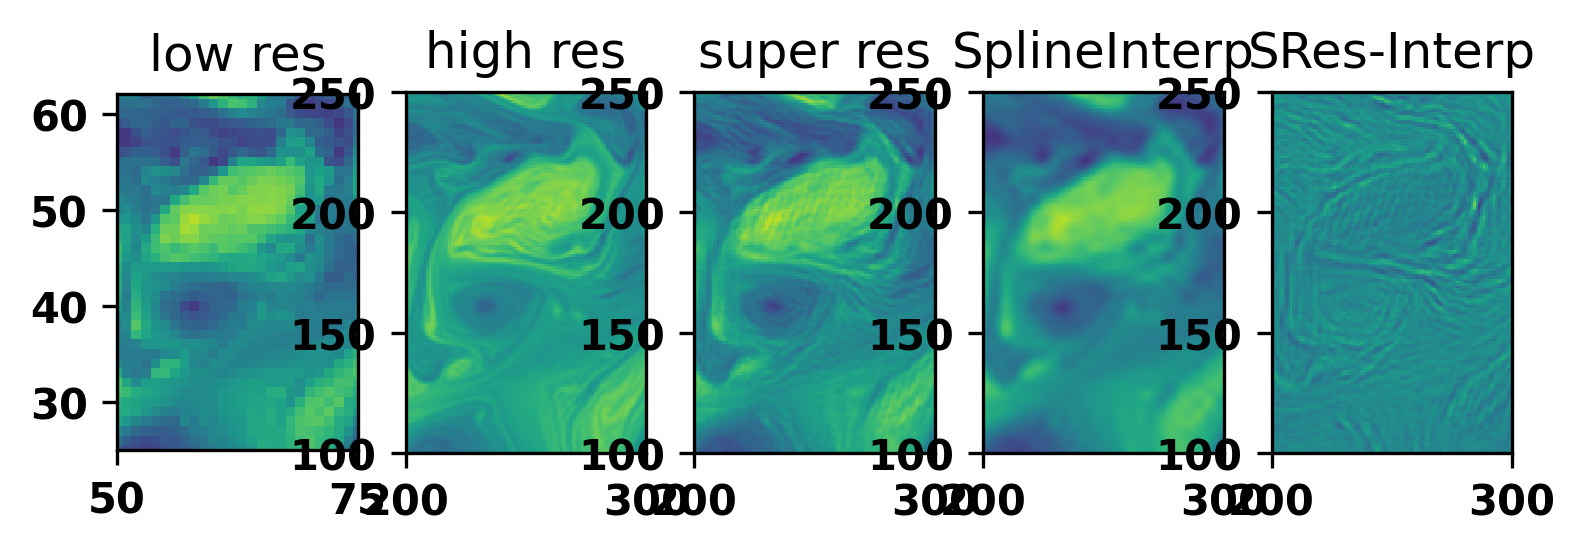

In [27]:
%matplotlib inline

plt.figure(dpi= 300)

high_res_xlim =  [200, 300]
high_res_ylim =  [100, 250]

plt.subplot(1, 5, 1)
plt.imshow(low_res.T, interpolation='none')

if high_res_xlim is not None:
    plt.xlim([high_res_xlim[0]//scaling_factor, high_res_xlim[1]//scaling_factor])
    plt.ylim([high_res_ylim[0]//scaling_factor, high_res_ylim[1]//scaling_factor])
plt.title("low res")

plt.subplot(1, 5, 2)
plt.imshow(high_res.T, interpolation='none')

if high_res_xlim is not None:
    plt.xlim([high_res_xlim[0], high_res_xlim[1]])
    plt.ylim([high_res_ylim[0], high_res_ylim[1]])
plt.title("high res")

plt.subplot(1, 5, 3)
plt.imshow(super_res.T, interpolation='none')

if high_res_xlim is not None:
    plt.xlim([high_res_xlim[0], high_res_xlim[1]])
    plt.ylim([high_res_ylim[0], high_res_ylim[1]])
plt.title("super res")

plt.subplot(1, 5, 4)
plt.imshow(interped_res.T, interpolation='none')

if high_res_xlim is not None:
    plt.xlim([high_res_xlim[0], high_res_xlim[1]])
    plt.ylim([high_res_ylim[0], high_res_ylim[1]])
plt.title("SplineInterp")

plt.subplot(1, 5, 5)
plt.imshow(super_res.T - interped_res.T, interpolation='none')

if high_res_xlim is not None:
    plt.xlim([high_res_xlim[0], high_res_xlim[1]])
    plt.ylim([high_res_ylim[0], high_res_ylim[1]])
plt.title("SRes-Interp")

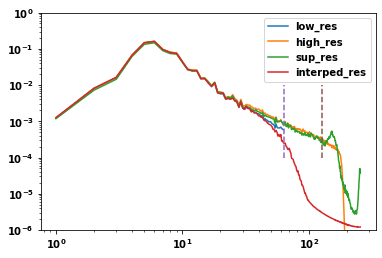

In [28]:
for field_name, field_value in [("low_res", low_res),   ("high_res", high_res), 
                                ("sup_res", super_res), ("interped_res", interped_res)]:
    if isinstance(field_value, torch.Tensor):
        field_value = field_value.numpy()
    spec = cal_enstrophy_spec(field_value)
    plt.loglog(*spec, label=field_name)

orignal_size = low_res.shape[-1] / 2
plt.plot([orignal_size, orignal_size], [1e-4, 1e-2], "--")
plt.ylim([1e-6, 1])

plt.plot([orignal_size*2, orignal_size*2], [1e-4, 1e-2], "--")
plt.ylim([1e-6, 1])

plt.legend()

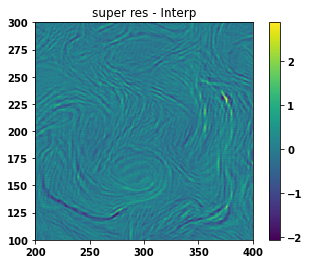

In [24]:
#plt.figure(dpi= 300)

plt.imshow(super_res.T - interped_res.T, interpolation='nearest')

# if high_res_xlim is not None:
#     plt.xlim([high_res_xlim[0], high_res_xlim[1]])
#     plt.ylim([high_res_ylim[0], high_res_ylim[1]])
plt.title("super res - Interp")
plt.xlim([200, 400])
plt.ylim([100, 300])
plt.colorbar()